In [1]:
import os
from dotenv import load_dotenv

load_dotenv('/home/TomKerby/Research/langchain-academy/.env', override=True)
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [2]:
import operator
from typing import Annotated
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from IPython.display import Image, display

class HelperState(MessagesState):
    context: Annotated[list, operator.add]
    search_query: str
    search_question: str
    summary: str

In [3]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model='llama3.3', temperature=0)

In [4]:
gen_query_system_prompt = """
You are a query reformulator for a document search system. Your task is to generate an optimized search query that 
will be used to retrieve additional context from a document database. Analyze the entire conversation history as well 
as the latest user input. Reformulate the user's question by removing ambiguity, incorporating any relevant details 
or keywords from previous messages, and enhancing clarity and specificity. The goal is to produce a concise, precise 
query that maximizes the chances of retrieving useful documents. Make sure to output only the optimized search query 
with no additional explanation or commentary. The output should be exactly the query text.
"""

gen_question_system_prompt = """
You are a contextual query reformulator for a question-answering system. Your task is to enhance the user's question 
by incorporating relevant context from previous interactions. Analyze the entire conversation history along with the 
latest user query. If the latest question contains ambiguous references (e.g., pronouns like "they" or "it") or lacks 
necessary context, identify the key subject from previous questions and answers and explicitly include it in the 
reformulated query. For example, if a previous exchange involved the question "What is the fastest land mammal?" with 
the answer "cheetah" and the new question is "How long do they live?", your output should be: "How long do cheetahs 
live?". Output only the final reformulated query text with no additional explanation or commentary.
"""

In [ ]:
from langchain_community.document_loaders import WikipediaLoader
from typing import Literal

def generate_search_query(state: HelperState):
    messages = state["messages"]
    search_query = llm.invoke([SystemMessage(content=gen_query_system_prompt)]+messages)
    return {"search_query": search_query.content}

def reformulate_question(state: HelperState):
    messages = state["messages"]
    summary = state.get("summary", "")
    state['context'] = []
    if summary or len(messages) > 1:   
        search_query = llm.invoke([SystemMessage(content=gen_question_system_prompt)]+messages)
        return {"search_question": search_query.content}
    else:
        return {"search_question": state["messages"][-1].content}

def search_wikipedia(state: HelperState):
    max_query_length = 300
    trimmed_query = state['search_query'][:max_query_length]

    search_docs = WikipediaLoader(query=trimmed_query, 
                                  load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state: HelperState):
    """ Node to answer a question """
    context = "\n\n".join(state["context"])
    
    summary = state.get("summary", "")
    system_context = f"Summary of conversation earlier: {summary}" if summary else ""
    
    recent_chat_history = "\n".join([msg.content for msg in state["messages"][:-1]])
    
    answer_template = (
        "Using the following recent conversation history:\n"
        "{chat_history}\n\n"
        "and the additional context provided below:\n"
        "{context}\n\n"
        "Please generate a concise and accurate answer for the user."
    )
    answer_instructions = answer_template.format(
        chat_history=recent_chat_history,
        context=context
    )
    
    full_system_message = f"{system_context}\n\n{answer_instructions}" if system_context else answer_instructions

    response = llm.invoke([
        SystemMessage(content=full_system_message),
        HumanMessage(content=state['search_question'])
    ])

    return {"messages": [response]}


def summarize_conversation(state: HelperState):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: HelperState)->Literal["summarize_conversation", "__end__"]:
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    else:
        return "__end__"

In [6]:
import aiosqlite
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

def load_memory(db_path, async_run=True):
    if async_run:
        conn = aiosqlite.connect(db_path)
        memory = AsyncSqliteSaver(conn)
    else:
        conn = sqlite3.connect(db_path, check_same_thread=False)
        memory = SqliteSaver(conn)
    return memory

db_path = "./example.db"
memory = load_memory(db_path, async_run=True)

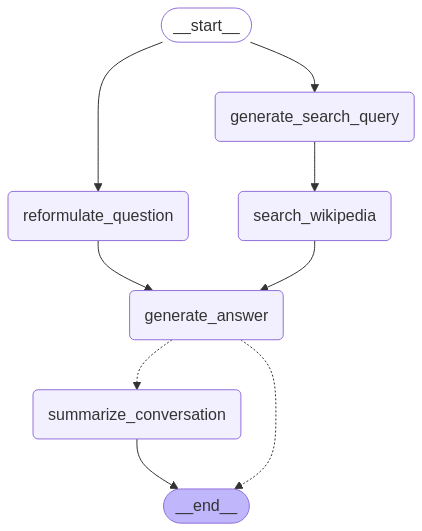

In [7]:
builder = StateGraph(HelperState)

builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)
builder.add_node("generate_search_query", generate_search_query)
builder.add_node("reformulate_question", reformulate_question)
builder.add_node("summarize_conversation", summarize_conversation)

# Flow
builder.add_edge(START, "generate_search_query")
builder.add_edge(START, "reformulate_question")
builder.add_edge("generate_search_query", "search_wikipedia")
builder.add_edge(["reformulate_question", "search_wikipedia"], "generate_answer")
builder.add_conditional_edges("generate_answer", should_continue)
builder.add_edge("summarize_conversation", END)
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [8]:
async def stream_agent_output(
    agent_graph,
    text_input,
    node_to_stream='generate_answer',
    thread_id="1",
    node_completion=True
):
    config = {"configurable": {"thread_id": thread_id}}
    input_message = HumanMessage(content=text_input)
    last_node = None
    async for event in agent_graph.astream_events({"messages": [input_message]}, config, version="v2"):
        node = event['metadata'].get('langgraph_node', '').strip()
        if node and node != last_node and node_completion:
            print(node)
            last_node = node
        if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
            data = event["data"]
            print(data["chunk"].content, end="")

In [9]:
thread_id = "1"
text_input = "When did BYU become a university?"
await stream_agent_output(graph, text_input, thread_id=thread_id, node_completion=False)

According to the provided text, Brigham Young University-Idaho (BYU-Idaho) was previously known as Ricks College and transitioned from a junior college to a baccalaureate institution in 2001, at which point it became a university. However, the main Brigham Young University (BYU), located in Provo, Utah, is not mentioned in the provided text as having a specific date for becoming a university. If you're looking for information on the main BYU, I'd be happy to try and help you find that information.

In [10]:
text_input = "When did the university enter the Big XII conference?"
await stream_agent_output(graph, text_input, thread_id=thread_id, node_completion=False)

Brigham Young University (BYU) has not entered the Big 12 Conference. However, BYU did join the Big 12 Conference on September 10, 2021, and began competing in the conference on July 1, 2023. Prior to joining the Big 12, BYU was a member of the West Coast Conference (WCC) for most sports and competed as an independent in football.

In [11]:
text_input = "What official sports teams does BYU have?"
await stream_agent_output(graph, text_input, thread_id=thread_id, node_completion=False)

That's correct! The athletic teams of Brigham Young University (BYU) are indeed called the BYU Cougars. They compete in the National Collegiate Athletic Association (NCAA) Division I and are part of the Big 12 Conference.

The BYU Cougars have a wide range of sports teams, including:

1. Football
2. Men's basketball
3. Women's basketball
4. Baseball
5. Softball
6. Volleyball
7. Soccer
8. Gymnastics
9. Track and field
10. Cross country
11. Golf
12. Tennis

The university has a strong athletic program, with many of its teams having achieved significant success over the years. The BYU Cougars have won numerous conference championships and have appeared in several NCAA tournaments.

It's worth noting that BYU is known for its unique culture and values, which are reflected in its athletic programs. The university is owned and operated by The Church of Jesus Christ of Latter-day Saints (LDS Church), and as such, it has a strong emphasis on sportsmanship, integrity, and character development.

In [12]:
text_input = "How well is BYU doing in athletics as they transition into being a full member of the Big XII conference?"
await stream_agent_output(graph, text_input, thread_id=thread_id, node_completion=False)

As of my knowledge cutoff, Brigham Young University (BYU) has indeed joined the Big 12 Conference, and their athletic teams, known as the Cougars, have been competing in various sports. However, I don't have real-time information on their current performance.

That being said, I can provide some general context and insights. BYU's transition to the Big 12 Conference marks a significant change for the university's athletic programs. The Big 12 is a Power Five conference, which means that BYU will be competing against some of the top athletic programs in the country.

In terms of their performance, it's likely that BYU's teams will face stiff competition in the Big 12. The conference is home to traditional powerhouses like Oklahoma, Texas, and Kansas, among others. However, BYU has a strong athletic tradition and has been competitive in various sports, including football, basketball, and volleyball.

To get a better sense of how BYU is performing in athletics as a member of the Big 12 Co

In [13]:
# print(result['summary'])